# Analyze traffic accident data to identify patterns related to road conditions, weather and time of day. visualize accident hotspots and contributing factors
dataset: https://www.kaggle.com/code/harshalbhamare/us-accident-eda

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point

In [25]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/PRODIGY Internship/PRODIGY_DS_05/US_Accidents_Dec21_updated.csv')

# Overview of the data
print("Dataset shape:", df.shape)
print(df.columns)

Dataset shape: (2845342, 47)
Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


##  1. Time of Day Analysis

<ipython-input-26-c256a780b0e2>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




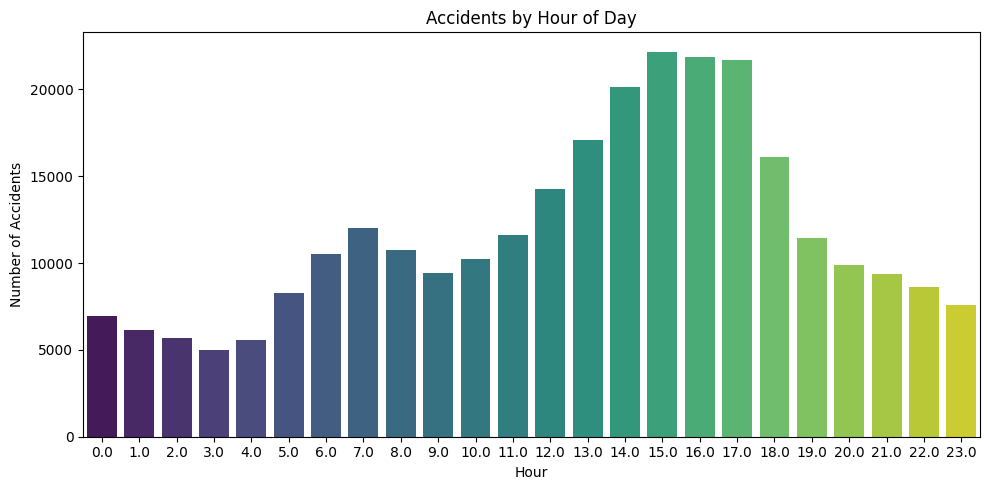

In [26]:
# Convert 'Start_Time' to datetime, handling nanoseconds
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

# Extract hour
df['Hour'] = df['Start_Time'].dt.hour

# Plot accident frequency by hour
plt.figure(figsize=(10, 5))
sns.countplot(x='Hour', data=df, palette='viridis')
plt.title('Accidents by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

##  2. Weather Conditions

<ipython-input-27-df4f8c26413c>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




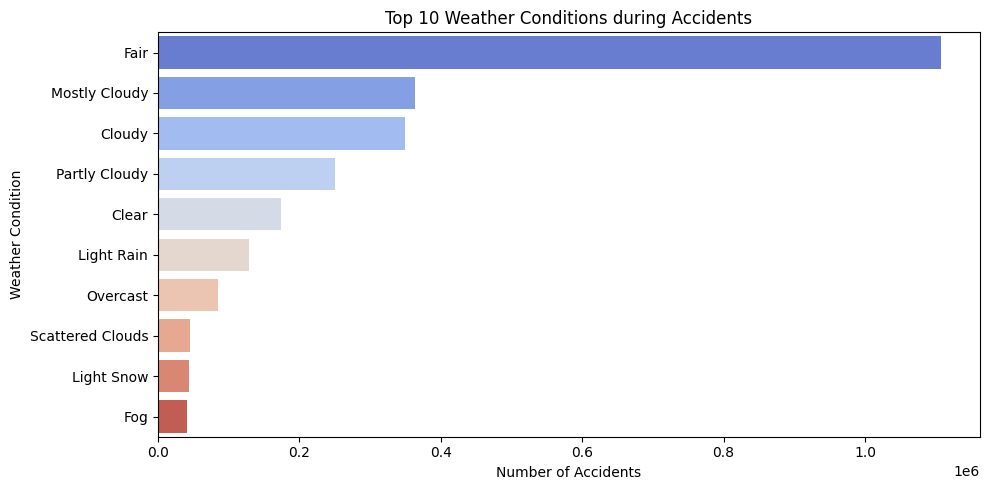

In [27]:
weather_counts = df['Weather_Condition'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=weather_counts.values, y=weather_counts.index, palette='coolwarm')
plt.title('Top 10 Weather Conditions during Accidents')
plt.xlabel('Number of Accidents')
plt.ylabel('Weather Condition')
plt.tight_layout()
plt.show()

## 3. Road Conditions

<ipython-input-28-fd9f35c24b03>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




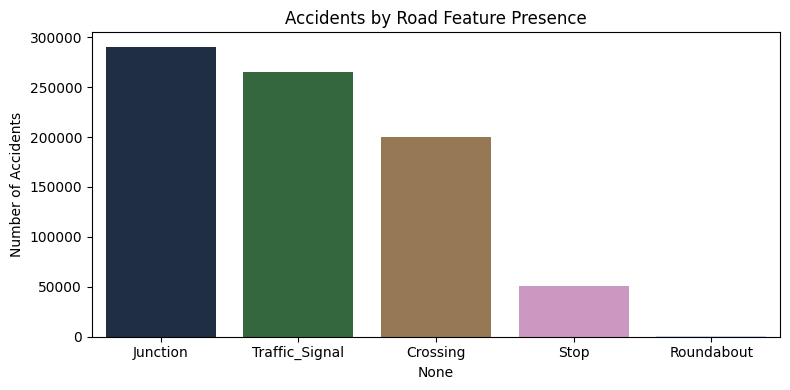

In [28]:
road_features = ['Crossing', 'Junction', 'Traffic_Signal', 'Stop', 'Roundabout']
road_stats = df[road_features].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=road_stats.index, y=road_stats.values, palette='cubehelix')
plt.title('Accidents by Road Feature Presence')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

## 4. Accident Hotspots (Map)

In [29]:
# Set the renderer for Google Colab
pio.renderers.default = 'colab'

# Sample 10,000 rows with valid coordinates
geo_df = df[['Start_Lat', 'Start_Lng']].dropna().sample(10000)

# Create density map
fig = px.density_mapbox(
    geo_df, lat='Start_Lat', lon='Start_Lng',
    radius=5,
    center=dict(lat=39.8283, lon=-98.5795),  # Center of US
    zoom=3,
    mapbox_style='open-street-map',  # No token required
    title='Accident Density Hotspots in the US'
)

fig.show()


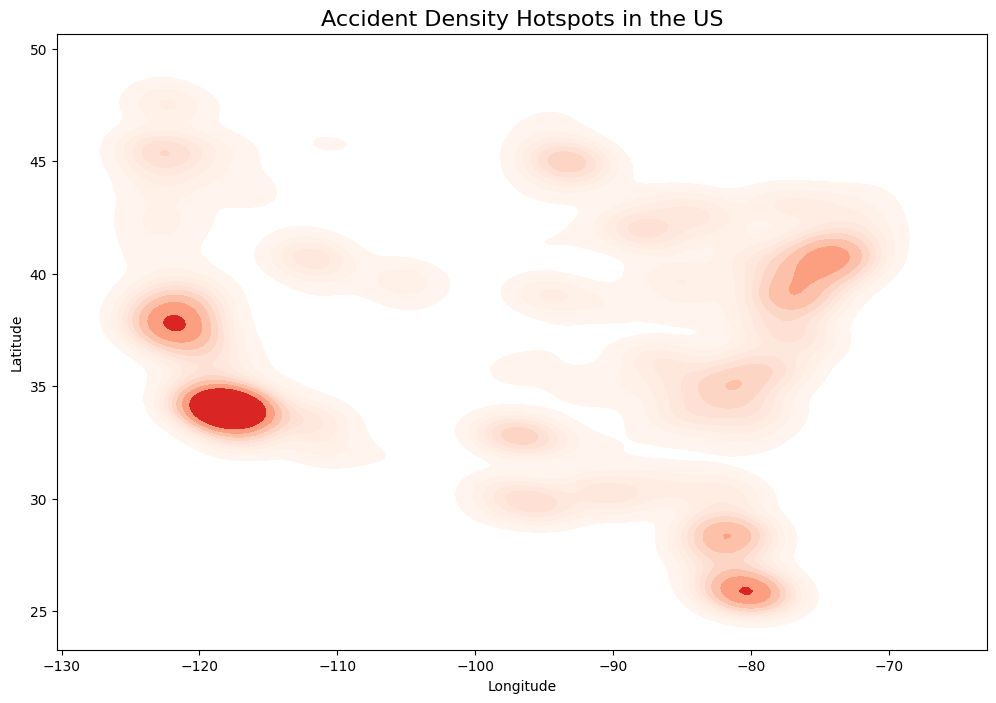

In [30]:
# Sample 10,000 points with valid coordinates
geo_df = df[['Start_Lat', 'Start_Lng']].dropna().sample(10000)

# Set the figure size
plt.figure(figsize=(12, 8))

# Use seaborn to create a KDE heatmap
sns.kdeplot(
    x=geo_df['Start_Lng'],
    y=geo_df['Start_Lat'],
    cmap="Reds",
    fill=True,
    bw_adjust=0.5,
    thresh=0.05
)

# Add labels and title
plt.title('Accident Density Hotspots in the US', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

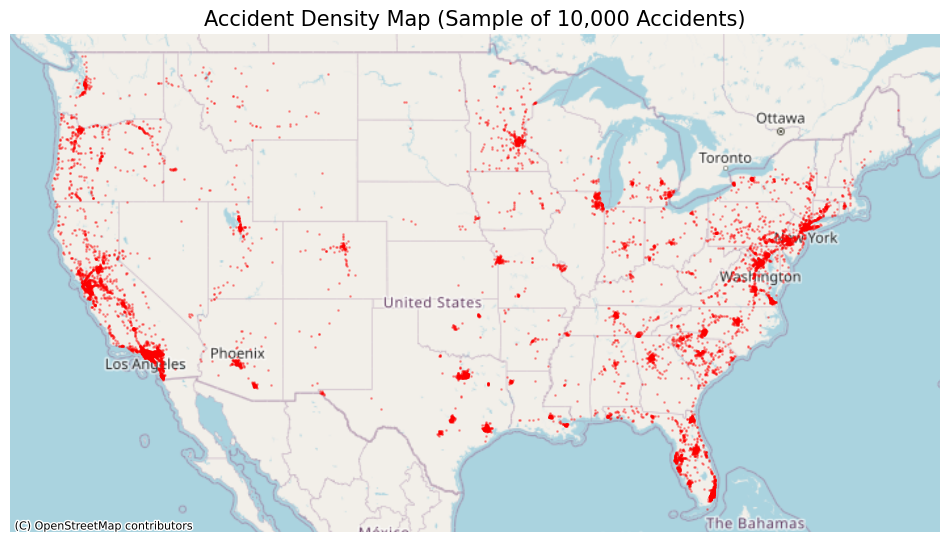

In [32]:
# Sample 10,000 points with valid coordinates
geo_df = df[['Start_Lat', 'Start_Lng']].dropna().sample(10000)

# Create geometry column with Point objects
geometry = [Point(xy) for xy in zip(geo_df['Start_Lng'], geo_df['Start_Lat'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(geo_df, geometry=geometry, crs="EPSG:4326")  # WGS84

# Project to Web Mercator (required by contextily)
gdf = gdf.to_crs(epsg=3857)

# Plot the points with a KDE-like scatter plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the points (alpha controls transparency)
gdf.plot(ax=ax, markersize=1, alpha=0.3, color='red')

# Add basemap from contextily using a different provider
# Stamen is obsolete, using OpenStreetmap instead
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Set title and remove axis
ax.set_title("Accident Density Map (Sample of 10,000 Accidents)", fontsize=15)
ax.set_axis_off()

plt.show()

## 5. Accidents by State

<ipython-input-33-a947b478ce74>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




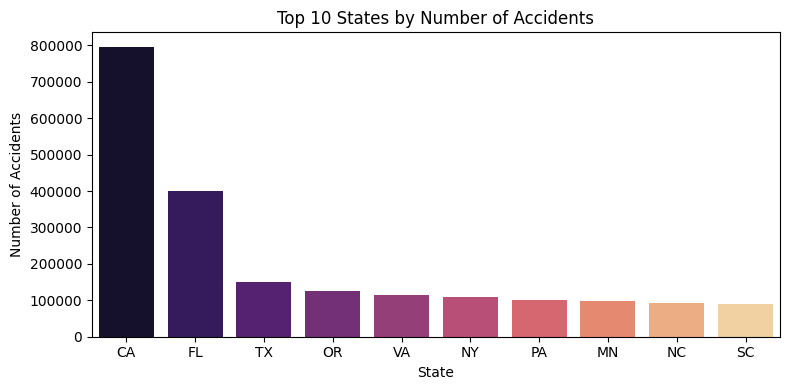

In [33]:
top_states = df['State'].value_counts().head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_states.index, y=top_states.values, palette='magma')
plt.title('Top 10 States by Number of Accidents')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

### 🔍 Key Insights You’ll Uncover

• Time of Day: Morning and evening rush hours have the highest accident rates.

• Weather: Most accidents occur in clear weather, not during storms.

• Road Features: Junctions and missing traffic signals are frequent accident spots.

• Hotspots: Accidents cluster around big cities and coasts.

• Top States: California, Texas, and Florida lead in accident numbers.

